In [2]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [20]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pickle

from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata 
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.deep_learning.soundtype_classifier.classify_sounds_metadata import classify_sounds_metadata
from src.util import make_image

%matplotlib inline

### Parameters

In [54]:
# path to metadata
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

# what to classify
colonies = ['dothrakib']
dates = 'all'
experiments = 'all'
stages = ['traced and checked', 'labeled and checked', 'split and checked']
stages = 'all'
classes_to_drop = ['weirdo', 'badsplit', 'noise',]

path_to_models = PATH_TO_PROJECT + 'models/classifier/networks/'
path_to_datasets = PATH_TO_PROJECT + 'models/classifier/datasets/'
all_models = os.listdir(path_to_datasets)
print('\n'.join(all_models))

nmr_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
dam_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
hvd_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
berlin_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000
bsuil_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=300


In [55]:
# Choose what model to use
model_name = all_models[3]
print(model_name)

berlin_im-augment=5_nfft=512_nmel=80_tdim=64_rec-denoise=False_highpass=3000


### Loading data

In [56]:
# Load model
model = tf.keras.models.load_model(path_to_models + model_name)
# Load labels from the model and sounds metadata to test the model on
with open(path_to_datasets + model_name + '/params_dict.pickle', 'rb') as f:
    all_params_dict = pickle.load(f)
all_classes = np.load(path_to_datasets + model_name + '/all_classes.npy')
recs_to_classify, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages)
print(recs_to_classify.shape)
recs_to_classify.head()

Using 25 recordings
(25, 8)


,colony,date,experiment,name,number,path,processing stage,ratids
0,dothrakib,22-08-19,single rat softchirps,dothrakib_22-08-19_3318_0000018.npy,18.0,/home/gr1/Projects/naked-mole-rats//data/dothr...,traced and checked,3318
1,dothrakib,22-08-19,single rat softchirps,dothrakib_22-08-19_3314_0000014.npy,14.0,/home/gr1/Projects/naked-mole-rats//data/dothr...,traced and checked,3314
2,dothrakib,22-08-19,single rat softchirps,dothrakib_22-08-19_3321_0000021.npy,21.0,/home/gr1/Projects/naked-mole-rats//data/dothr...,traced and checked,3321
3,dothrakib,22-08-19,single rat softchirps,dothrakib_22-08-19_3302_0000002.npy,2.0,/home/gr1/Projects/naked-mole-rats//data/dothr...,traced and checked,3302
4,dothrakib,22-08-19,single rat softchirps,dothrakib_22-08-19_3322_0000022.npy,22.0,/home/gr1/Projects/naked-mole-rats//data/dothr...,traced and checked,3322


### Classification

In [57]:
# Whether to save the results
save = False
# Reload data. Useful when you rerun this cell, so that you won't classify same data twice
# Probabl won't be needed in the script format
recs_to_classify, recs_dict = load_recordings_metadata(path_to_recordings_metadata, recordings_metadata_name,
                                                    dates, colonies, experiments, stages,
                                                    preloaded_recs_dict=recs_dict)
print('%d recs to classify' % (len(recs_to_classify)))
# Classification
for rec_name, rec_path in recs_to_classify[['name', 'path']].values:
    time_start = time.time()
    rec_ind = np.where(recs_to_classify['name'] == rec_name)[0][0]
    print('Classifying recording %s of length %.2f seconds' % (rec_name, len(recs_dict[rec_name]) / 22050))
    df_txt = pd.read_csv(rec_path + rec_name[:-3] + 'txt', sep = '\t')
    if len(df_txt) == 0:
        print('No splits in the txt file, moving to the next one')
        continue
    sounds_in_rec_metadata = generate_sounds_metadata(recs_to_classify[rec_ind: rec_ind + 1], classes_to_drop, {}, 
                                                      0, np.inf, sr=all_params_dict['sr'],  print_counts=False)
    predicted_labels, melspecs = classify_sounds_metadata(model, sounds_in_rec_metadata, recs_dict, all_classes,
                                                          all_params_dict, return_grouped=False)
    for ind, s in enumerate(sounds_in_rec_metadata['s']):
        ind_in_txt = np.where(df_txt['s'] == s)[0][0]
        df_txt['cl'].iloc[ind_in_txt] = predicted_labels[ind]
    print('Finished!Classification took %.2f seconds' % (time.time() - time_start))
    if save:
        recs_metadata['processing stage'].iloc[rec_ind] = 'labeled'
        df_txt.to_csv(rec_path + rec_name[:-3] + 'txt', sep = '\t', index = None)
        recs_metadata.to_csv(path_to_recordings_metadata + recordings_metadata_name, index  = None)
    else:
        print('Save is False, not saving anything')
        break

Using 25 recordings
25 recs to classify
Classifying recording dothrakib_22-08-19_3318_0000018.npy of length 45.82 seconds


/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:36: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)
/home/gr1/Projects/naked-mole-rats/src/deep_learning/soundtype_classifier/classify_sounds_metadata.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  for sound in sounds_npy_aug])
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_wave.py:31: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa.filters.mel(sr, n_fft=nfft, n_mels=n_mel)
2022-04-24 16:52:38.624951: W

2022-04-24 16:52:40.478090: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:40.551061: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:40.622708: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:40.701700: W tensorflow/stream_executor/gpu/

2022-04-24 16:52:42.470311: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:42.543607: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:42.615740: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:42.688718: W tensorflow/stream_executor/gpu/

2022-04-24 16:52:44.457506: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:44.530018: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:44.602559: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:44.676837: W tensorflow/stream_executor/gpu/

2022-04-24 16:52:46.484125: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:46.564559: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:46.652124: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



Finished!Classification took 8.47 seconds
Save is False, not saving anything


2022-04-24 16:52:46.741195: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:46.819310: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-24 16:52:46.897002: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/pan

### Look at the results (uses the recording that was classified last)

In [58]:
df_txt['cl'].value_counts()

softchirp    19
Name: cl, dtype: int64

In [60]:
rec = recs_dict[rec_name]
img = make_image(rec)

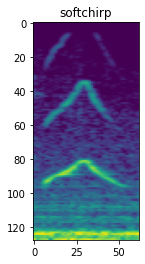

In [68]:
# show random splits
sec_to_px = 22050 / (len(rec) / img.shape[1])
i = np.random.randint(0, len(df_txt))
s_sec, e_sec = df_txt[['s', 'e']].iloc[i]
s_smp, e_smp = int(22050 * s_sec), int(22050 * e_sec)
s_px, e_px = int(sec_to_px * s_sec), int(sec_to_px * e_sec)

plt.imshow(img[:, s_px : e_px])
_ = plt.title(df_txt['cl'].iloc[i])